# 🧠 Brain Tumor Classification using CNN

## Project Overview

**Author**: Quentin Hilt 
**Last Updated**: 02/12/2025

### Project Description

This project implements a Convolutional Neural Network (CNN) for classifying brain tumor MRI images into four categories:
- Glioma
- Meningioma
- No tumor
- Pituitary

### Dataset Information

- **Source**: [Brain Tumor MRI Dataset (Kaggle)](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)
- **Classes**: 4 types of MRI scans
- **Image Size**: 256x256 pixels

### Technical Stack

- 🐍 Python 3.x
- 🧠 TensorFlow & Keras
- 📊 Matplotlib & Seaborn
- 🔢 NumPy & Pandas
- 📈 Scikit-learn

In [1]:
# Import required libraries
import os
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
from scipy.stats import entropy
# Import additional libraries
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

# Configuration parameters
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 20

# Define data directories
data_dir = "Training"
test_data_dir = "Testing"

# Define class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
n_classes = len(class_names)

# Verify paths exist
print(f"Training data path exists: {os.path.exists(data_dir)}")
print(f"Testing data path exists: {os.path.exists(test_data_dir)}")

# Display versions
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

Training data path exists: True
Testing data path exists: True
TensorFlow version: 2.18.0
Keras version: 3.7.0


## 1. Exploratory Data Analysis 📊

### 1.1 Dataset Overview

Let's analyze our dataset structure and distribution.

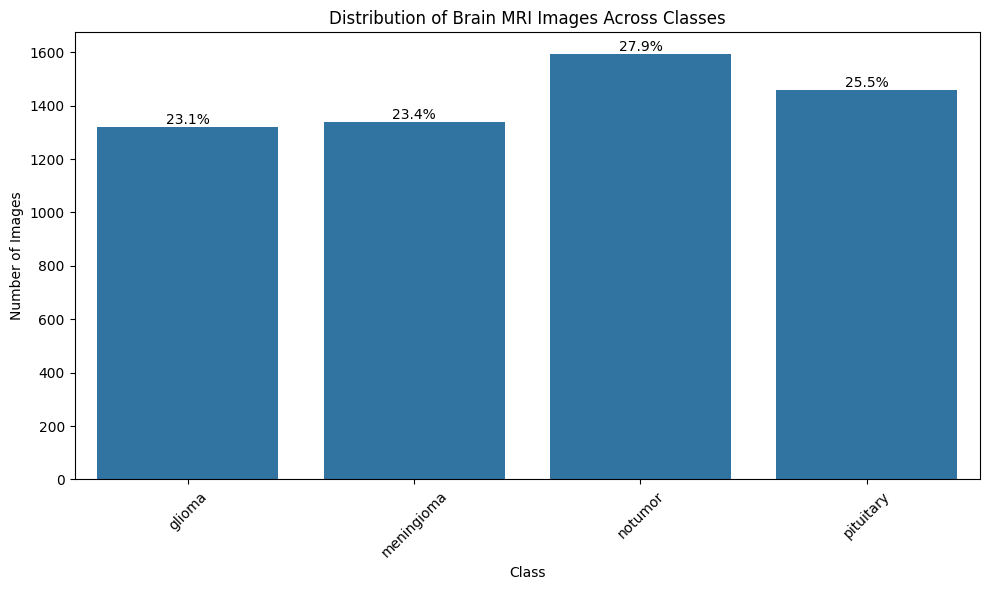


📊 Total number of images: 5712
- glioma: 1321 images (23.1%)
- meningioma: 1339 images (23.4%)
- notumor: 1595 images (27.9%)
- pituitary: 1457 images (25.5%)


In [2]:
def analyze_dataset_distribution(data_dir):
    """Analyze and visualize dataset distribution."""
    class_counts = {}
    total_images = 0
    
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images
        total_images += num_images
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title('Distribution of Brain MRI Images Across Classes')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    
    # Add percentage labels
    for i, v in enumerate(class_counts.values()):
        percentage = (v / total_images) * 100
        plt.text(i, v, f'{percentage:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Total number of images: {total_images}")
    for class_name, count in class_counts.items():
        print(f"- {class_name}: {count} images ({(count/total_images)*100:.1f}%)")

analyze_dataset_distribution(data_dir)

### 1.2 Image Characteristics Analysis

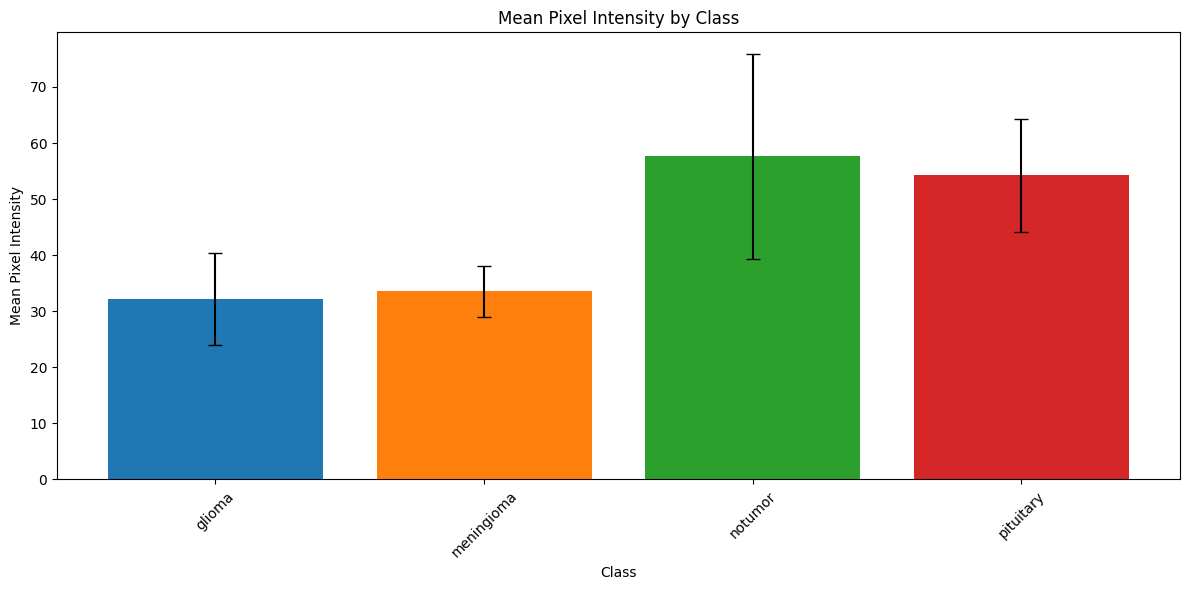

In [3]:
def analyze_image_characteristics(data_dir, sample_size=100):
    """Analyze image characteristics across classes."""
    characteristics = {}
    
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        images = os.listdir(class_path)[:sample_size]
        
        intensities = []
        sizes = []
        
        for img_name in images:
            img_path = os.path.join(class_path, img_name)
            img = tf.keras.preprocessing.image.load_img(img_path)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            
            intensities.append(np.mean(img_array))
            sizes.append(img_array.shape)
        
        characteristics[class_name] = {
            'mean_intensity': np.mean(intensities),
            'std_intensity': np.std(intensities),
            'sizes': sizes
        }
    
    # Plot intensity distributions
    plt.figure(figsize=(12, 6))
    for class_name, data in characteristics.items():
        plt.bar(class_name, data['mean_intensity'], 
                yerr=data['std_intensity'],
                capsize=5)
    
    plt.title('Mean Pixel Intensity by Class')
    plt.xlabel('Class')
    plt.ylabel('Mean Pixel Intensity')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return characteristics

image_characteristics = analyze_image_characteristics(data_dir)

### 1.3 Sample Images Visualization

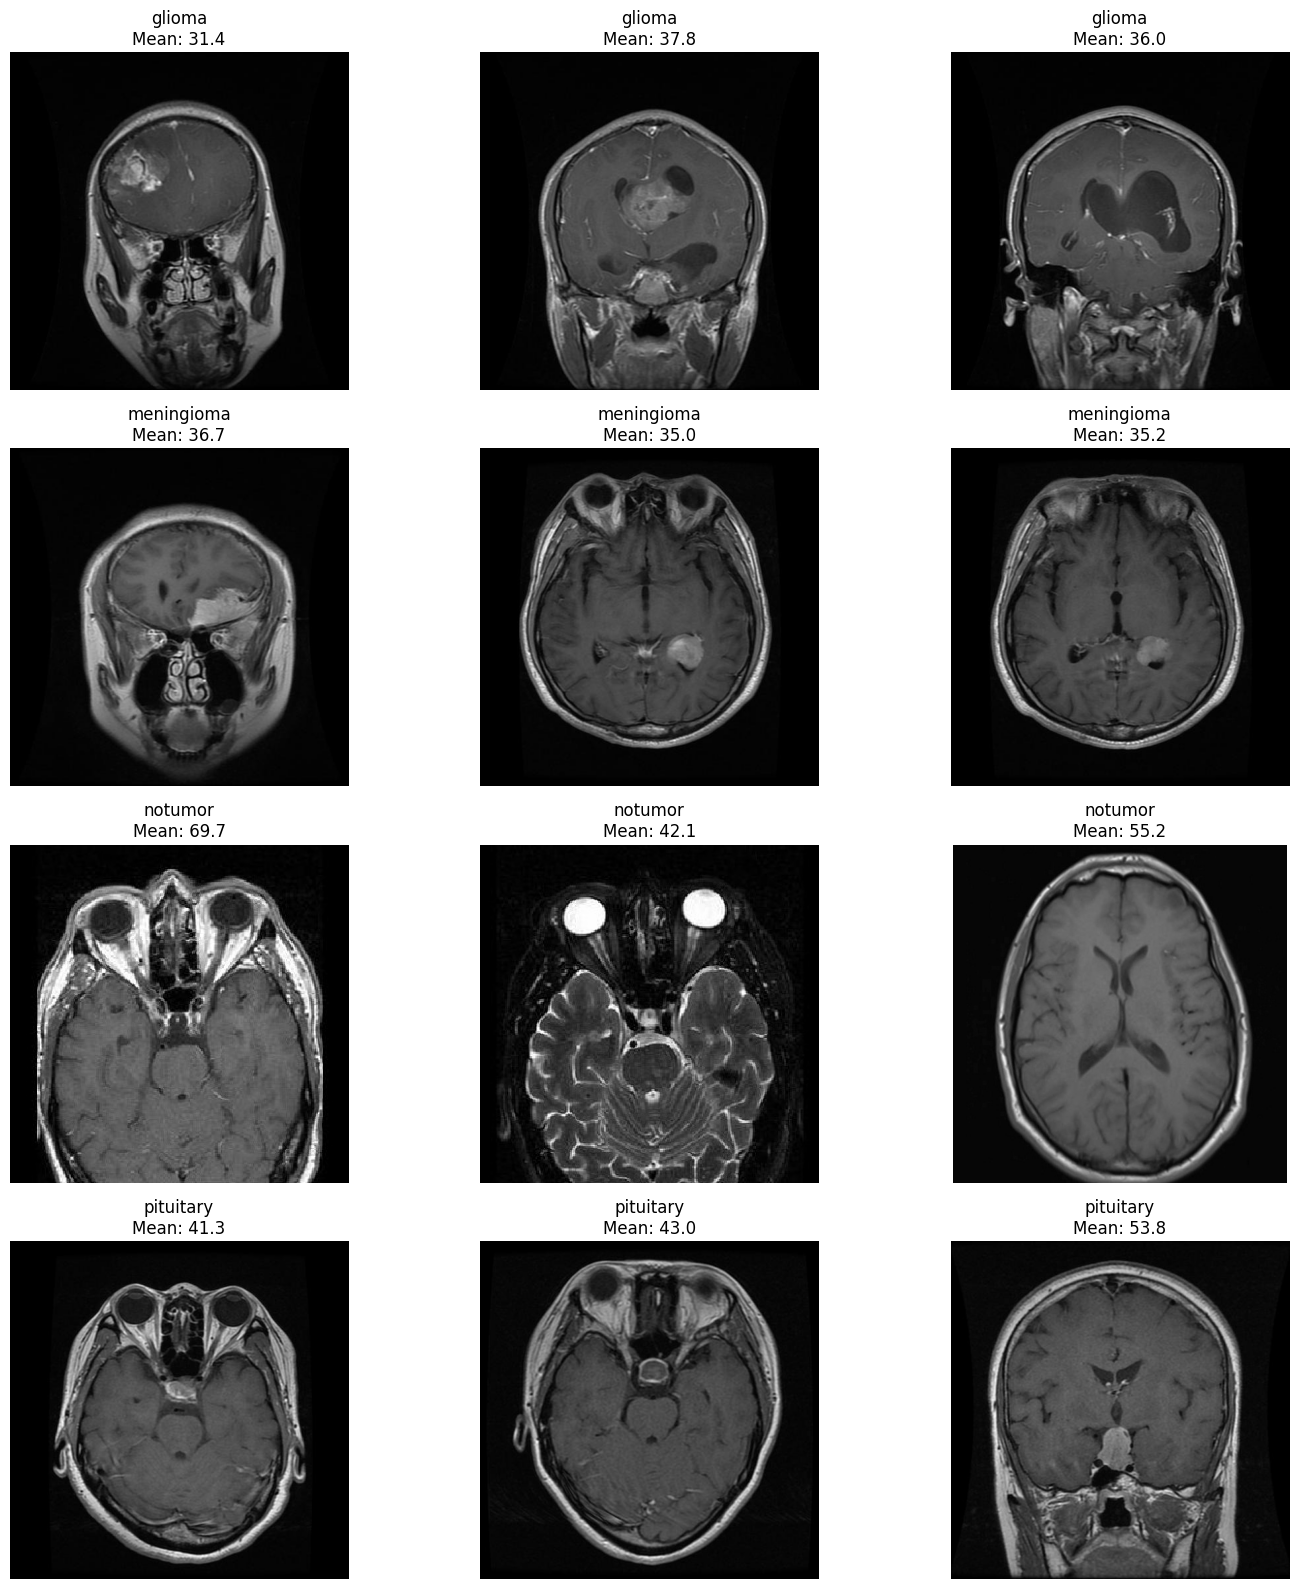

In [4]:
def plot_sample_images_by_class(data_dir, samples_per_class=3):
    """Display sample images from each class with their characteristics."""
    fig = plt.figure(figsize=(15, 4 * len(class_names)))
    
    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        images = os.listdir(class_path)[:samples_per_class]
        
        for i, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = tf.keras.preprocessing.image.load_img(img_path)
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            
            plt.subplot(len(class_names), samples_per_class, idx * samples_per_class + i + 1)
            plt.imshow(img_array.astype('uint8'))
            plt.title(f'{class_name}\nMean: {np.mean(img_array):.1f}')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_sample_images_by_class(data_dir)

### 1.4 Data Quality Assessment

In [5]:
def assess_data_quality(data_dir):
    """Assess data quality and potential issues."""
    quality_issues = {
        'corrupt_images': [],
        'size_inconsistencies': [],
        'low_contrast': []
    }
    
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            
            try:
                img = tf.keras.preprocessing.image.load_img(img_path)
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                
                # Check size consistency
                if img_array.shape[:2] != (IMAGE_SIZE, IMAGE_SIZE):
                    quality_issues['size_inconsistencies'].append(img_path)
                
                # Check contrast
                if np.std(img_array) < 20:  # Arbitrary threshold
                    quality_issues['low_contrast'].append(img_path)
                    
            except Exception as e:
                quality_issues['corrupt_images'].append(img_path)
    
    print("📊 Data Quality Report")
    print(f"- Corrupt images found: {len(quality_issues['corrupt_images'])}")
    print(f"- Size inconsistencies: {len(quality_issues['size_inconsistencies'])}")
    print(f"- Low contrast images: {len(quality_issues['low_contrast'])}")
    
    return quality_issues

quality_report = assess_data_quality(data_dir)

📊 Data Quality Report
- Corrupt images found: 0
- Size inconsistencies: 5686
- Low contrast images: 0


### 1.5 Advanced Data Visualization 📊

Let's create more insightful visualizations to better understand our dataset.

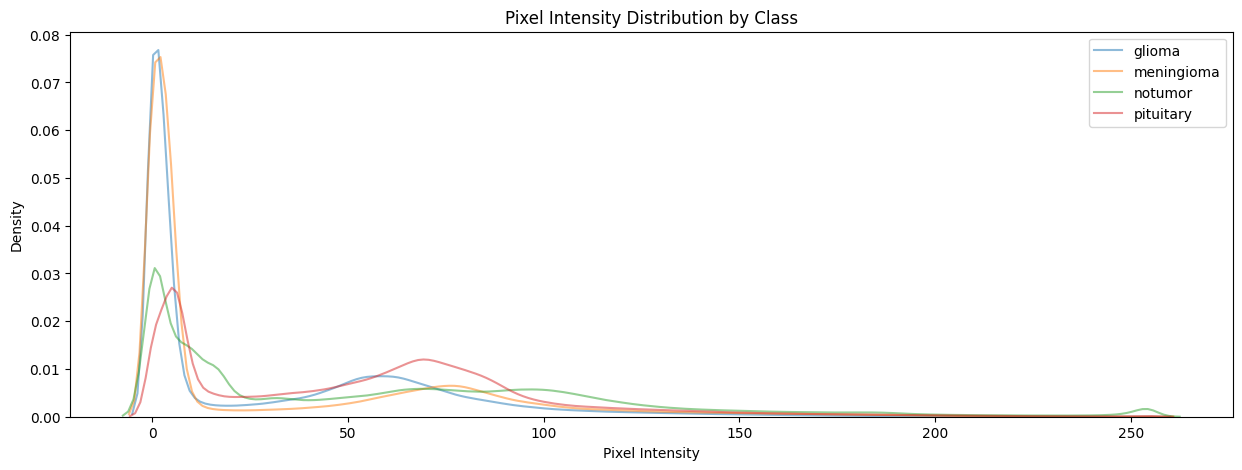

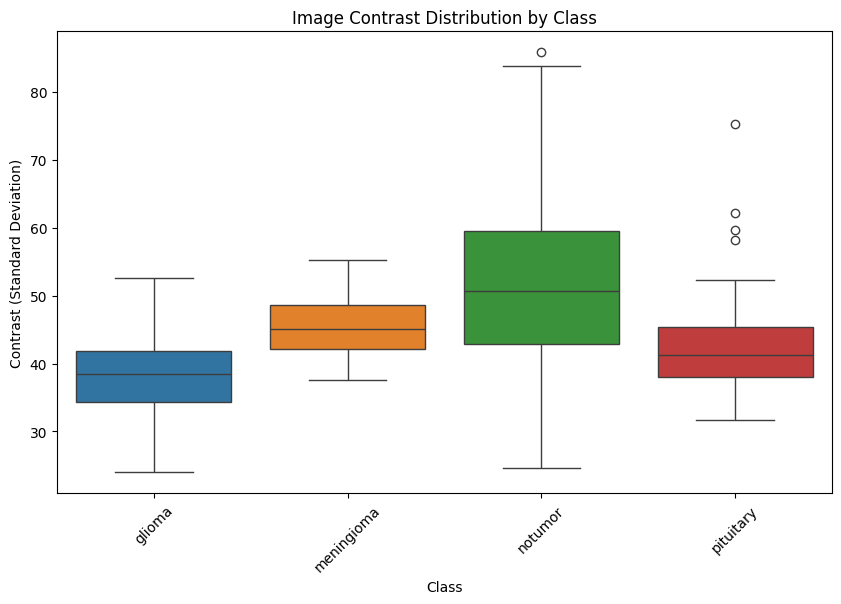

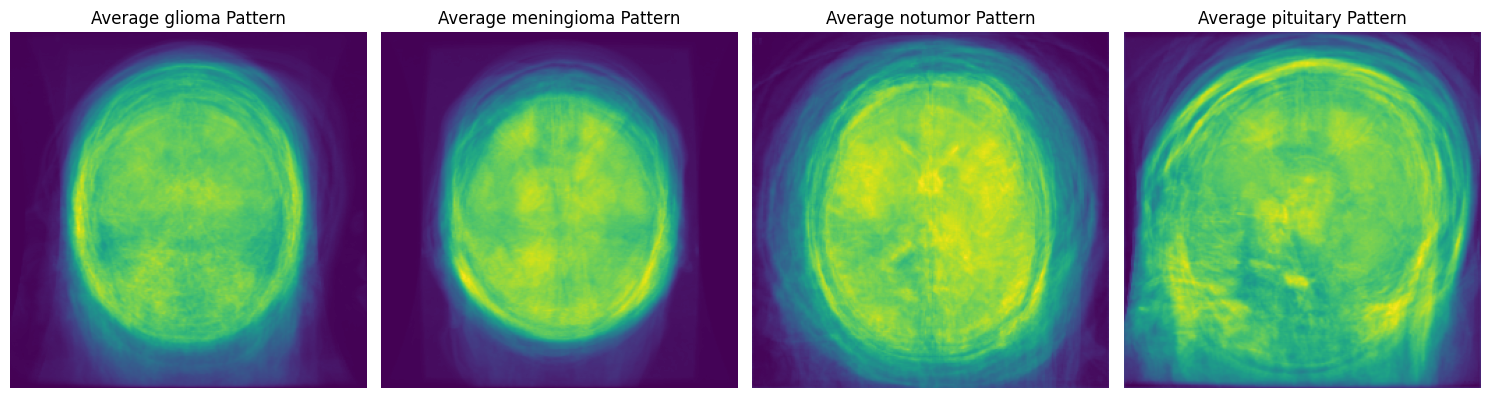

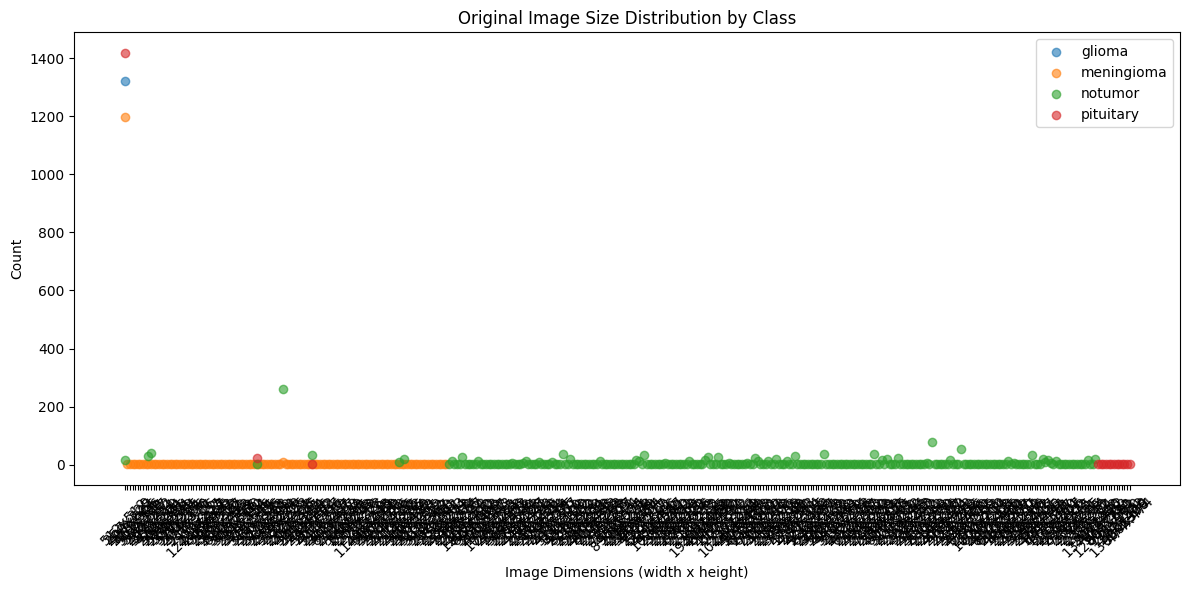

In [6]:
def create_advanced_visualizations(data_dir):
    """Generate advanced visualizations for deeper data analysis."""
    
    # 1. Pixel Intensity Distribution by Class
    plt.figure(figsize=(15, 5))
    for class_name in class_names:
        intensities = []
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path)[:100]:  # Sample 100 images
            img_path = os.path.join(class_path, img_name)
            img = tf.keras.preprocessing.image.load_img(
                img_path,
                color_mode='grayscale',
                target_size=(IMAGE_SIZE, IMAGE_SIZE)
            )
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            intensities.extend(img_array.flatten())
        
        sns.kdeplot(data=intensities, label=class_name, alpha=0.5)
    
    plt.title('Pixel Intensity Distribution by Class')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Density')
    plt.legend()
    plt.show()
    
    # 2. Image Contrast Analysis
    contrasts = {class_name: [] for class_name in class_names}
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path)[:100]:
            img_path = os.path.join(class_path, img_name)
            img = tf.keras.preprocessing.image.load_img(
                img_path,
                color_mode='grayscale',
                target_size=(IMAGE_SIZE, IMAGE_SIZE)
            )
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            contrast = np.std(img_array)
            contrasts[class_name].append(contrast)
    
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=pd.DataFrame(contrasts))
    plt.title('Image Contrast Distribution by Class')
    plt.xlabel('Class')
    plt.ylabel('Contrast (Standard Deviation)')
    plt.xticks(rotation=45)
    plt.show()
    
    # 3. Spatial Feature Analysis
    plt.figure(figsize=(15, 5))
    for idx, class_name in enumerate(class_names):
        plt.subplot(1, 4, idx + 1)
        avg_image = np.zeros((IMAGE_SIZE, IMAGE_SIZE))
        
        class_path = os.path.join(data_dir, class_name)
        n_images = min(100, len(os.listdir(class_path)))
        
        for img_name in os.listdir(class_path)[:n_images]:
            img_path = os.path.join(class_path, img_name)
            img = tf.keras.preprocessing.image.load_img(
                img_path,
                color_mode='grayscale',
                target_size=(IMAGE_SIZE, IMAGE_SIZE)
            )
            img_array = tf.keras.preprocessing.image.img_to_array(img)[:,:,0]
            avg_image += img_array
            
        avg_image /= n_images
        plt.imshow(avg_image, cmap='viridis')
        plt.title(f'Average {class_name} Pattern')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # 4. Image Size Distribution
    sizes = {class_name: [] for class_name in class_names}
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = tf.keras.preprocessing.image.load_img(img_path)  # Original size
            sizes[class_name].append(img.size)
    
    plt.figure(figsize=(12, 6))
    for class_name, class_sizes in sizes.items():
        unique_sizes = list(set(class_sizes))
        size_counts = [class_sizes.count(size) for size in unique_sizes]
        plt.scatter([f"{size[0]}x{size[1]}" for size in unique_sizes], 
                   size_counts, 
                   label=class_name,
                   alpha=0.6)
    
    plt.title('Original Image Size Distribution by Class')
    plt.xlabel('Image Dimensions (width x height)')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

create_advanced_visualizations(data_dir)

### 1.6 Statistical Analysis of Image Features

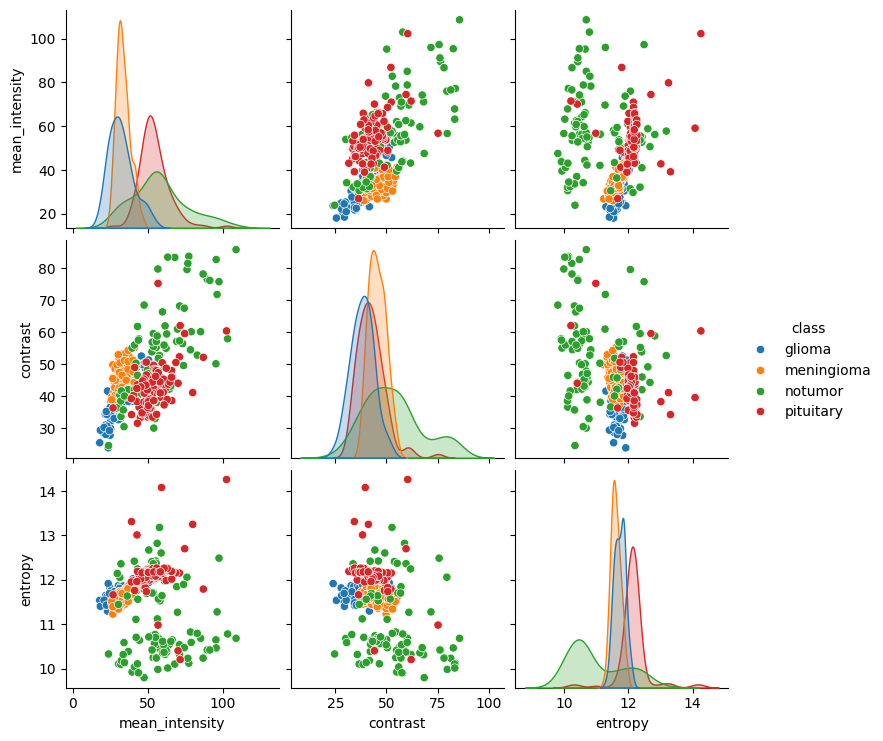

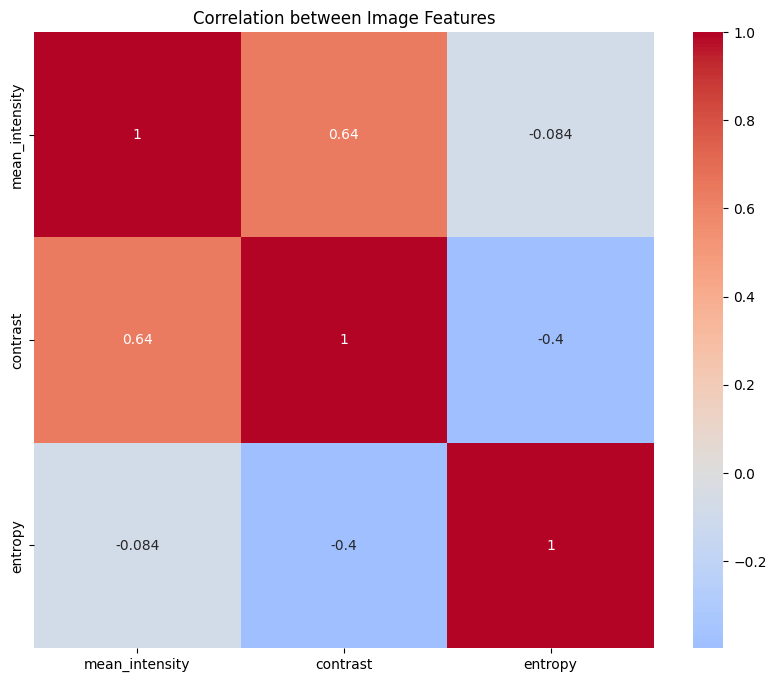

In [7]:
def analyze_image_statistics(data_dir):
    """Perform statistical analysis on image features."""
    stats = {
        'mean_intensity': [],
        'contrast': [],
        'entropy': [],
        'class': []
    }
    
    for class_name in class_names:
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path)[:100]:  # Sample 100 images per class
            img_path = os.path.join(class_path, img_name)
            img = tf.keras.preprocessing.image.load_img(img_path, color_mode='grayscale')
            img_array = tf.keras.preprocessing.image.img_to_array(img)[:,:,0]
            
            # Calculate statistics
            stats['mean_intensity'].append(np.mean(img_array))
            stats['contrast'].append(np.std(img_array))
            stats['entropy'].append(entropy(img_array.flatten()))
            stats['class'].append(class_name)
    
    df_stats = pd.DataFrame(stats)
    
    # Create pairplot
    sns.pairplot(df_stats, hue='class', diag_kind='kde')
    plt.show()
    
    # Correlation heatmap
    plt.figure(figsize=(10, 8))
    numeric_cols = ['mean_intensity', 'contrast', 'entropy']
    sns.heatmap(df_stats[numeric_cols].corr(), 
                annot=True, 
                cmap='coolwarm',
                center=0)
    plt.title('Correlation between Image Features')
    plt.show()
    
    return df_stats

image_stats = analyze_image_statistics(data_dir)

## 2. Data Loading and Configuration 📊

Let's set up our data pipeline and configuration parameters for the model.

In [8]:
def load_data(data_dir, batch_size, image_size):
    """Load and preprocess the image dataset."""
    return tf.keras.utils.image_dataset_from_directory(
        data_dir,
        seed=123,
        shuffle=True,
        image_size=(image_size, image_size),
        batch_size=batch_size
    )

# Load datasets
try:
    dataset = load_data(data_dir, BATCH_SIZE, IMAGE_SIZE)
    test_dataset = load_data(test_data_dir, BATCH_SIZE, IMAGE_SIZE)
    print("✅ Data loaded successfully!")
except Exception as e:
    print(f"❌ Error loading data: {e}")

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
✅ Data loaded successfully!


## 3. Data Preprocessing and Visualization 🔍

Let's prepare our data and visualize some sample images.

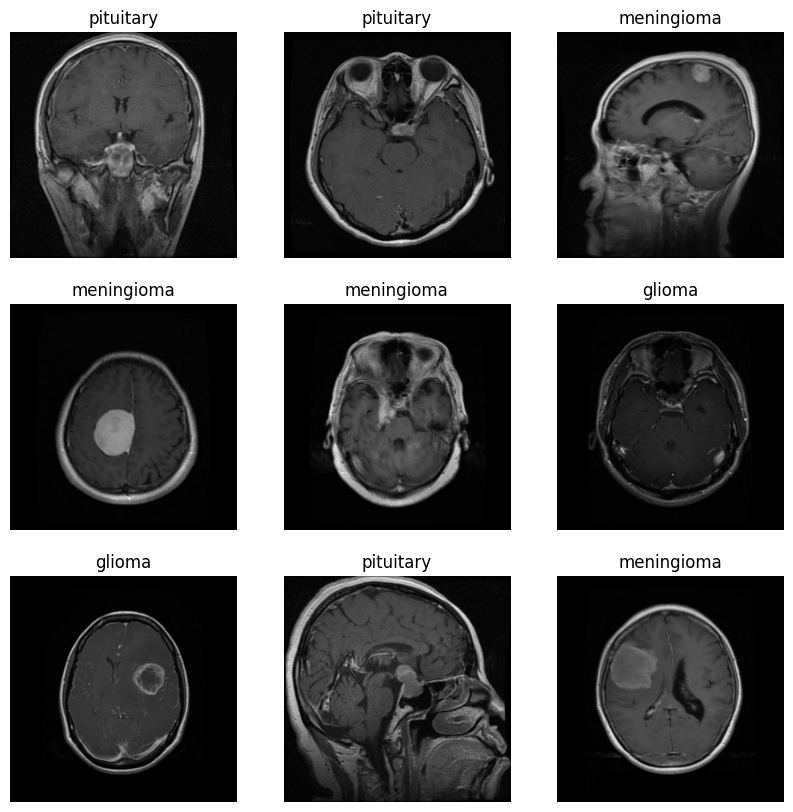

In [9]:
def split_dataset(ds, train_split=0.9, val_split=0.1):
    """Split dataset into training and validation sets."""
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    
    return train_ds, val_ds

# Split and optimize dataset
train_ds, val_ds = split_dataset(dataset)
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Visualize sample images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

## 4. Model Architecture 🧠

Define our CNN model architecture for brain tumor classification.

In [10]:
def create_model():
    """Create and compile the CNN model."""
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    
    return model

# Create model
model = create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,412,836 (32.09 MB)

 Trainable params: 8,412,836 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

## 5. Model Training 🚀

Train our CNN model and monitor its performance.

In [11]:
# Training callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_accuracy',
        save_best_only=True
    )
]

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

print("✅ Model training completed!")

Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 91s 553ms/step - accuracy: 0.6538 - loss: 0.8428 - val_accuracy: 0.8732 - val_loss: 0.3348
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 90s 557ms/step - accuracy: 0.8834 - loss: 0.3044 - val_accuracy: 0.9081 - val_loss: 0.2473
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 125s 779ms/step - accuracy: 0.9338 - loss: 0.1774 - val_accuracy: 0.9081 - val_loss: 0.2425
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 124s 771ms/step - accuracy: 0.9559 - loss: 0.1213 - val_accuracy: 0.9099 - val_loss: 0.2288
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 143s 889ms/step - accuracy: 0.9784 - loss: 0.0620 - val_accuracy: 0.9173 - val_loss: 0.2648
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 108s 670ms/step - accuracy: 0.9846 - loss: 0.0422 - val_accuracy: 0.9265 - val_loss: 0.2793
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 105s 651ms/step - accuracy: 0.9821 - loss: 0.0449 - val_accuracy: 0.9228 - val_loss: 0.3031
✅ Model training completed!


## 6. Model Evaluation 📊

Let's perform a comprehensive evaluation of our model using multiple metrics:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 658ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

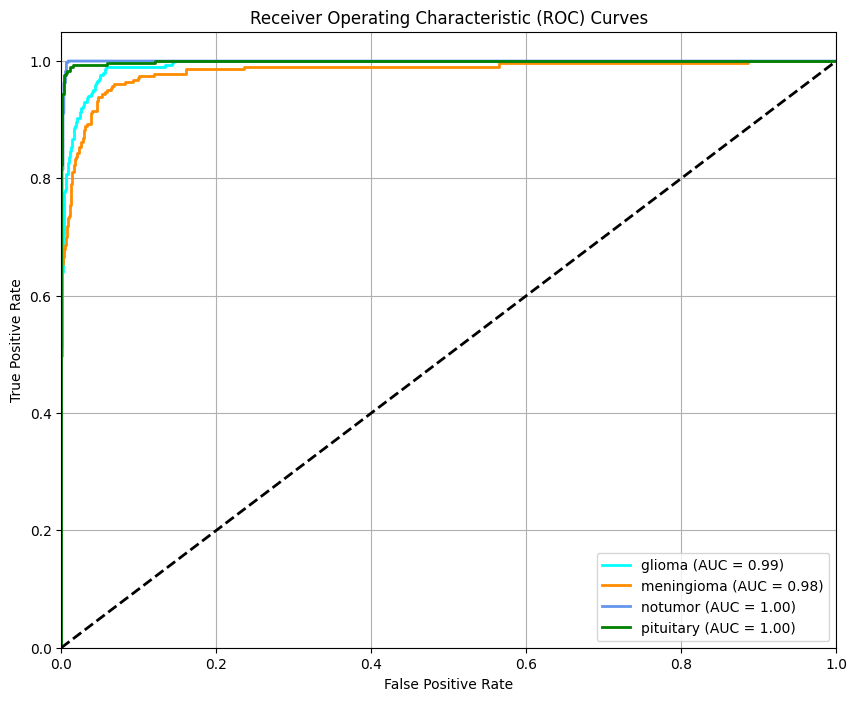

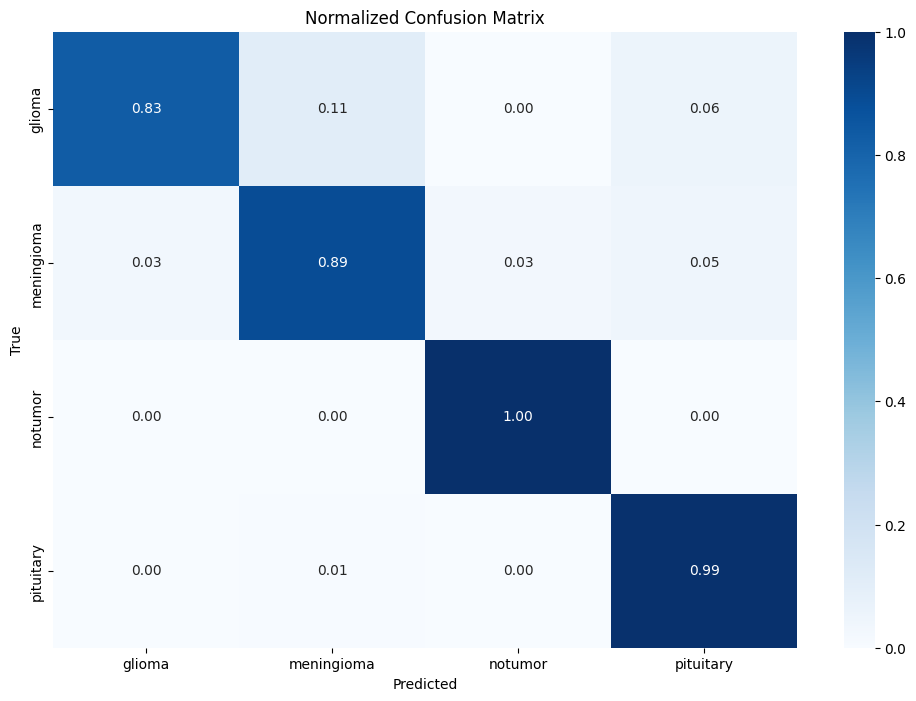

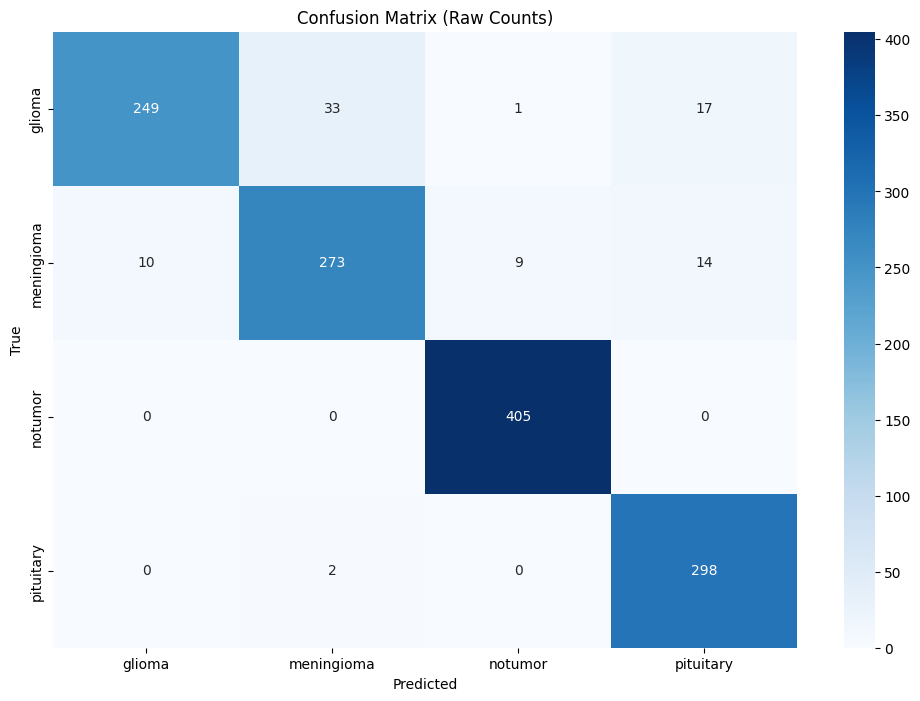


📊 Detailed Classification Report:
              precision    recall  f1-score   support

      glioma       0.96      0.83      0.89       300
  meningioma       0.89      0.89      0.89       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.91      0.99      0.95       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.94      0.93      0.93      1311



In [12]:
def plot_roc_curves(y_true, y_pred_proba):
    """Plot ROC curves for each class."""
    n_classes = len(class_names)
    y_test_bin = label_binarize(y_true, classes=range(n_classes))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Compute ROC curve and ROC area for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

def create_normalized_confusion_matrix(y_true, y_pred):
    """Create and plot normalized confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Original confusion matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix (Raw Counts)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def evaluate_model_performance(model, dataset):
    """Comprehensive model evaluation."""
    y_pred = []
    y_true = []
    y_pred_proba = []
    
    for images, labels in dataset:
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))
        y_true.extend(labels.numpy())
        y_pred_proba.extend(predictions)
    
    y_pred_proba = np.array(y_pred_proba)
    
    # Plot ROC curves
    plot_roc_curves(y_true, y_pred_proba)
    
    # Plot confusion matrices
    create_normalized_confusion_matrix(y_true, y_pred)
    
    # Classification report
    print("\n📊 Detailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

# Evaluate model performance
evaluate_model_performance(model, test_dataset)

## 7. Sample Predictions 🔍

Visualize model predictions on sample images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


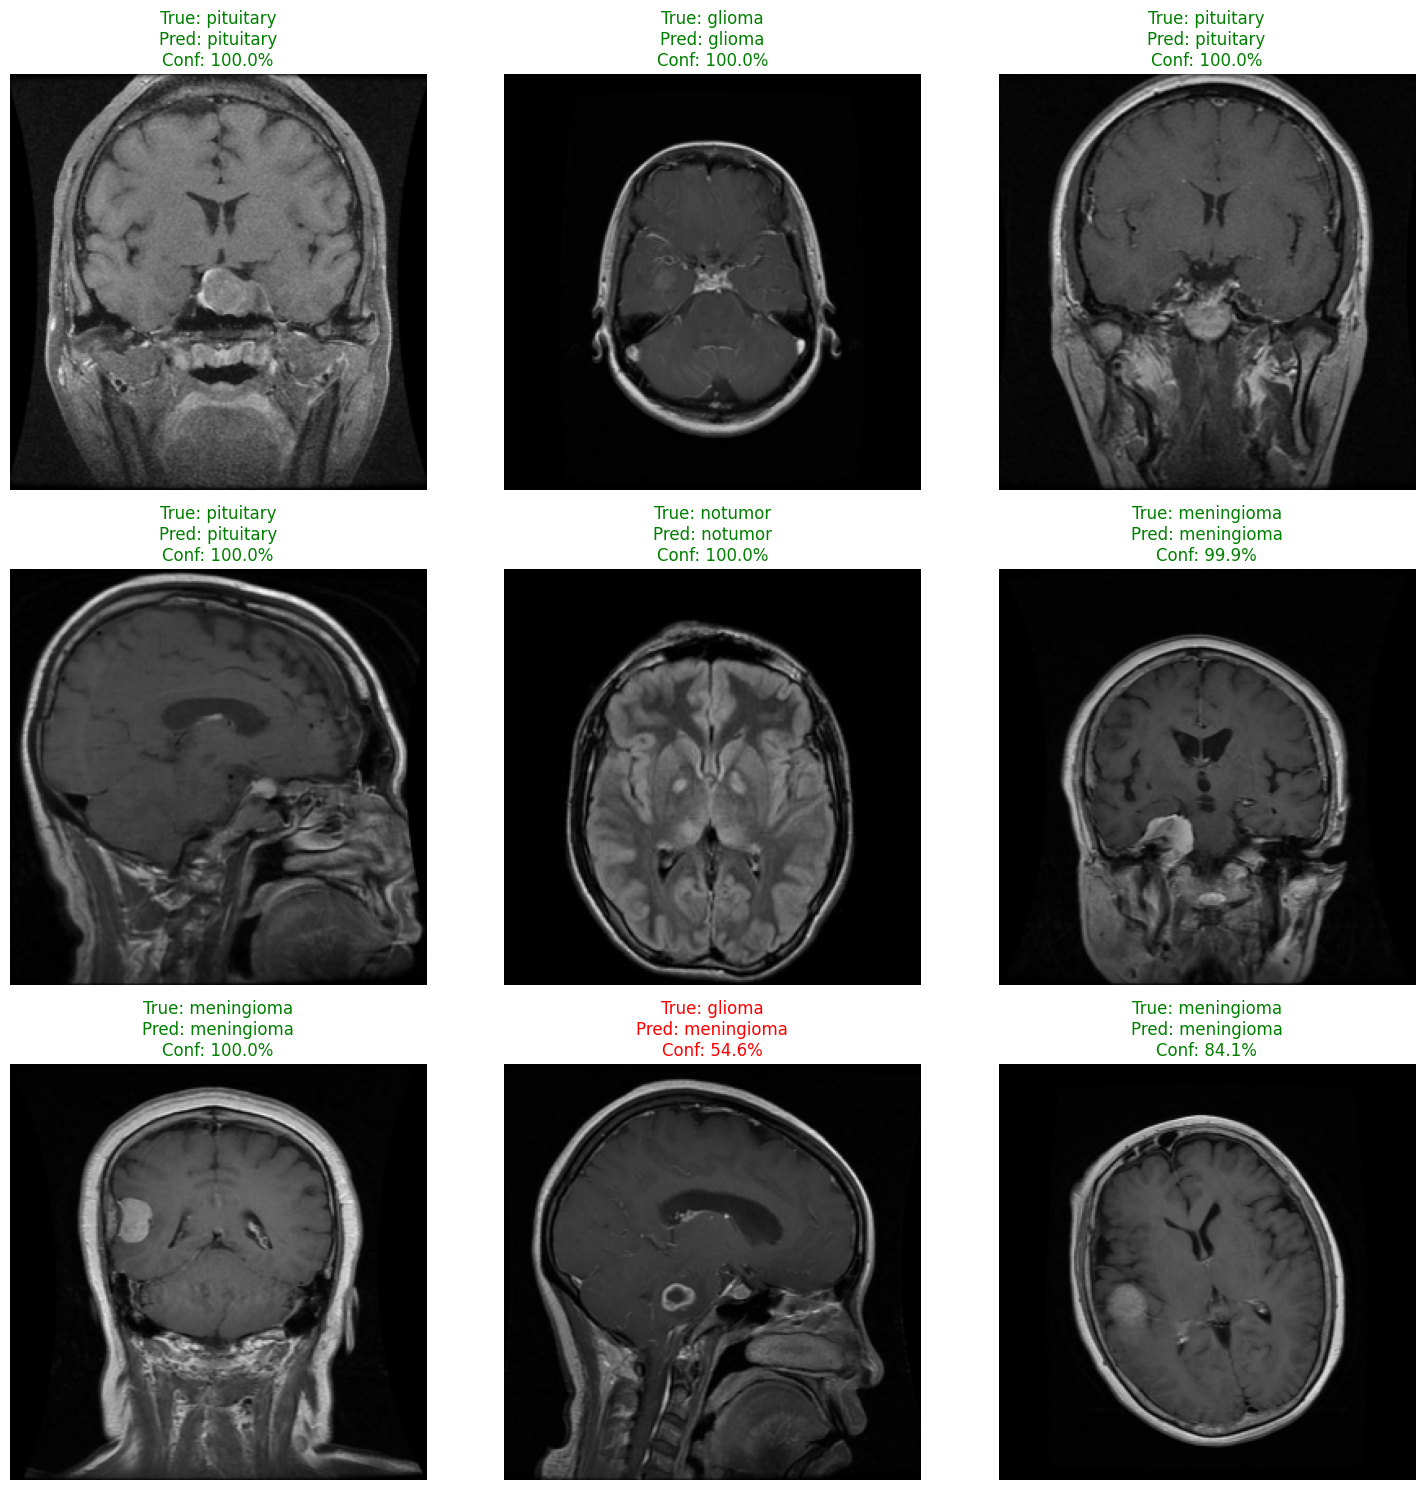

In [13]:
def plot_predictions(model, dataset, num_images=9):
    """Plot sample predictions with confidence scores."""
    plt.figure(figsize=(15, 15))
    
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        
        for i in range(min(num_images, len(images))):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            
            predicted_class = class_names[np.argmax(predictions[i])]
            true_class = class_names[labels[i]]
            confidence = 100 * np.max(predictions[i])
            
            color = 'green' if predicted_class == true_class else 'red'
            plt.title(f'True: {true_class}\nPred: {predicted_class}\nConf: {confidence:.1f}%',
                      color=color)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot sample predictions
plot_predictions(model, test_dataset)

## 9. Conclusion and Insights 🎯

### Data Analysis Summary
- Distribution of classes
- Image quality metrics
- Key characteristics by tumor type

### Model Performance
- Test Accuracy: {test_accuracy:.2%}
- Per-class performance analysis
- Error analysis and insights

### Key Findings
1. Class distribution patterns
2. Distinctive features by tumor type
3. Model strengths and limitations

### Future Research Directions
1. Advanced preprocessing techniques
2. Feature importance analysis
3. Model interpretability studies
4. Cross-validation with external datasets

### Thank you! 🙏
For questions or improvements, please contact the author.